In [1]:
library(ggplot2)
library(cowplot)
library(reshape2)
library(hues)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
asv_tab_full <- read.table("data/asv_table.tab", comment.char="", header=1, skip=1, sep="\t", row.names=1)
taxonomy <- read.table("data/taxonomy.tsv", sep="\t", header=1, row.names=1)
md <- read.table("data/METADATA.txt", sep="\t", header=1, row.names=1, comment.char="")
asv_tab <- scale(asv_tab_full, center=FALSE, scale=colSums(asv_tab_full))
asv_tab <- merge(taxonomy, asv_tab, by=0)
asv_tab <- melt(asv_tab[,! colnames(asv_tab) %in% c("Confidence")]) # Exclude the confidence column
asv_tab$variable <- gsub("^X","", asv_tab$variable)

Using Row.names, Taxon as id variables


In [3]:
cut_taxonomy_string <- function(x, n) {
    sp <- unlist(strsplit(x,";"))
    if (length(sp) >= n) {
        if (n>=5) {
            return(paste(sp[n-1],sp[n]))
        } else {
            return(paste(sp[n]))
        }
    } else {
        if (n>=5) {
            return(paste(sp[length(sp)-1], sp[length(sp)]))
        } else {
            return(paste(sp[length(sp)]))
        }
    }
}

get_melted_taxon_table <- function(n) {
    rel_abund_tab <- aggregate(asv_tab$value, by=list(asv_tab$variable, asv_tab$Taxon), FUN=sum)
    colnames(rel_abund_tab) <- c("SampleID", "Taxon", "RelAbund")
    rel_abund_tab$Classification <- unlist(lapply(as.character(rel_abund_tab$Taxon), function(x) cut_taxonomy_string(x, n)))
    rel_abund_tab
}

## Taxonomy Bar Plot

In [4]:
options(repr.plot.height=5, repr.plot.width=8)
taxonomy_barplot <- function(level) {
    genus_tab <- get_melted_taxon_table(level)
    mean_tab <- aggregate(genus_tab$RelAbund, by=list(genus_tab$SampleID, genus_tab$Classification), FUN=mean)
    if (level > 2) {
        abundant <- mean_tab[mean_tab$x > 0.05,"Group.2"]
    } else {
        abundant <- genus_tab$Classification
    }
    genus_tab[! genus_tab$Classification %in% abundant, "Classification"] <- "Other"
    genus_tab$Location <- md[genus_tab$SampleID,"location"]
    genus_tab$Location <- as.factor(genus_tab$Location)
    levels(genus_tab$Location) <- c("Palmetto Inland", "Palmetto Coast", "Vero Beach")
    genus_tab$SampleID <- as.factor(genus_tab$SampleID)
    levels(genus_tab$SampleID) <- c("VB1","VB2","VB3","VB4","PC1","PC2","PC3","PC4","PC5","PI1","PI2","PI3","PI4","PI5","PI6","PC6")
    ggplot(genus_tab, aes(x=SampleID, y=RelAbund, fill=Classification)) + 
        geom_bar(stat='identity', colour='black', size=0.25) + theme(legend.position='bottom', legend.text=element_text(size=5)) +
        facet_grid(.~Location, scales = "free") + xlab("Sample") + ylab("Relative Abundance") +
        scale_fill_manual(guide=guide_legend(nrow = 7), values=as.vector(iwanthue(length(unique(genus_tab$Classification)))))
   
}

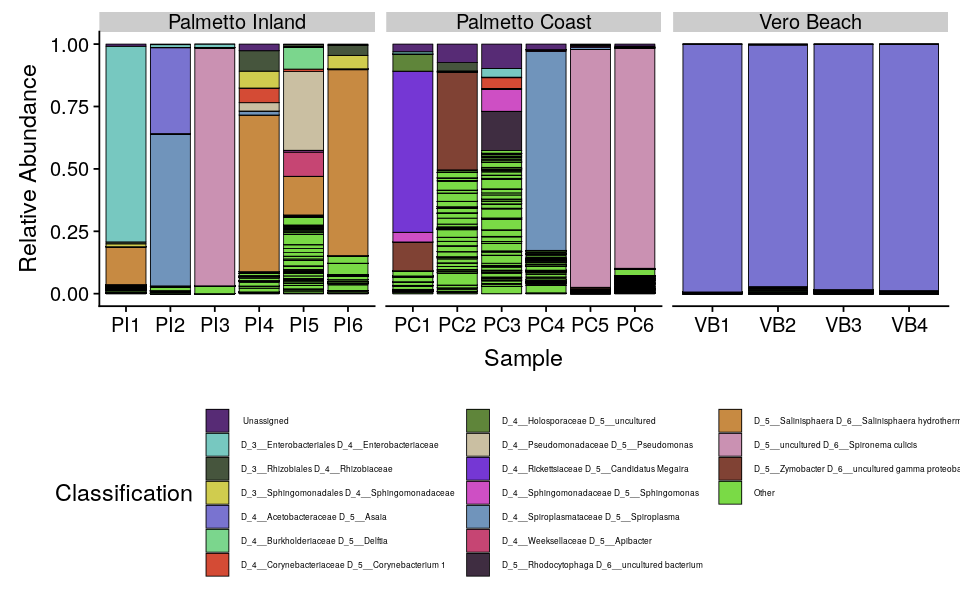

In [5]:
#pdf("Figure3.pdf", width=9, height=5)
taxonomy_barplot(7)
#dev.off()

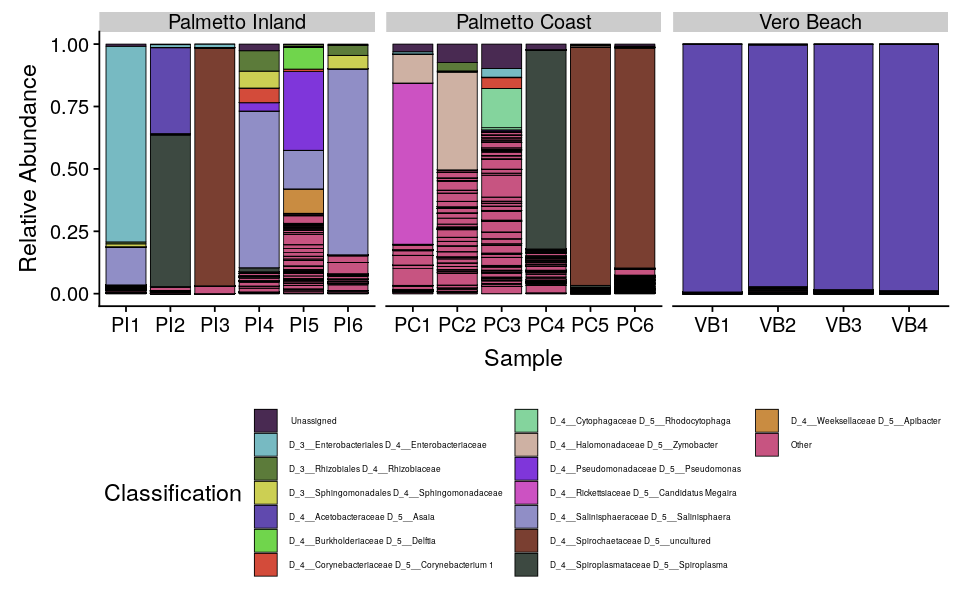

In [6]:
taxonomy_barplot(6)

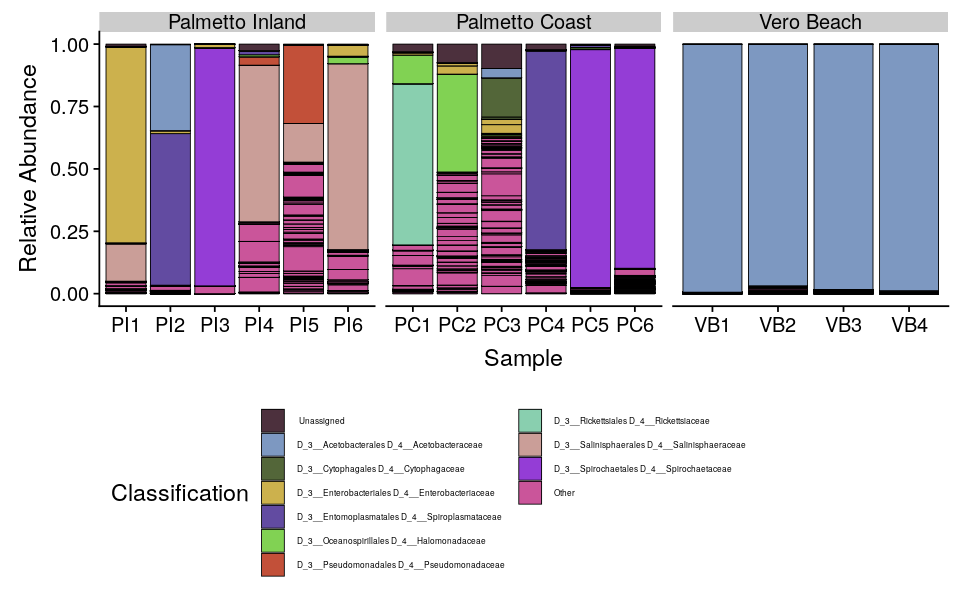

In [7]:
taxonomy_barplot(5)

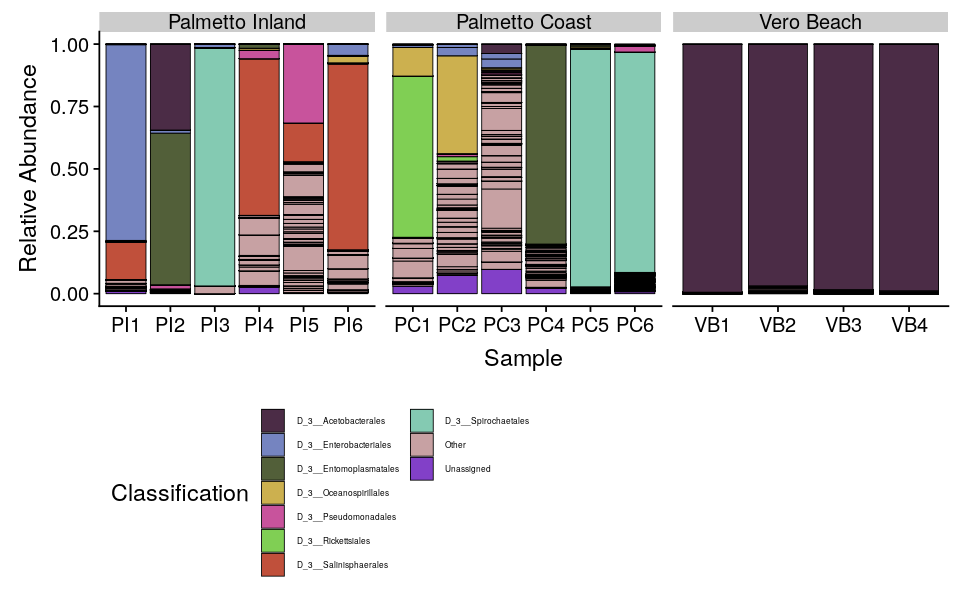

In [8]:
taxonomy_barplot(4)

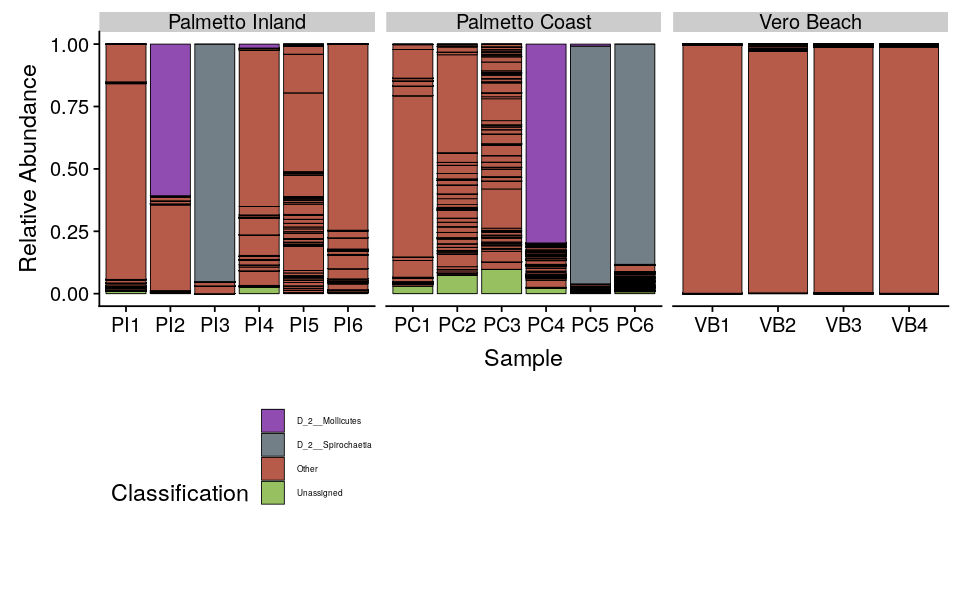

In [9]:
taxonomy_barplot(3)

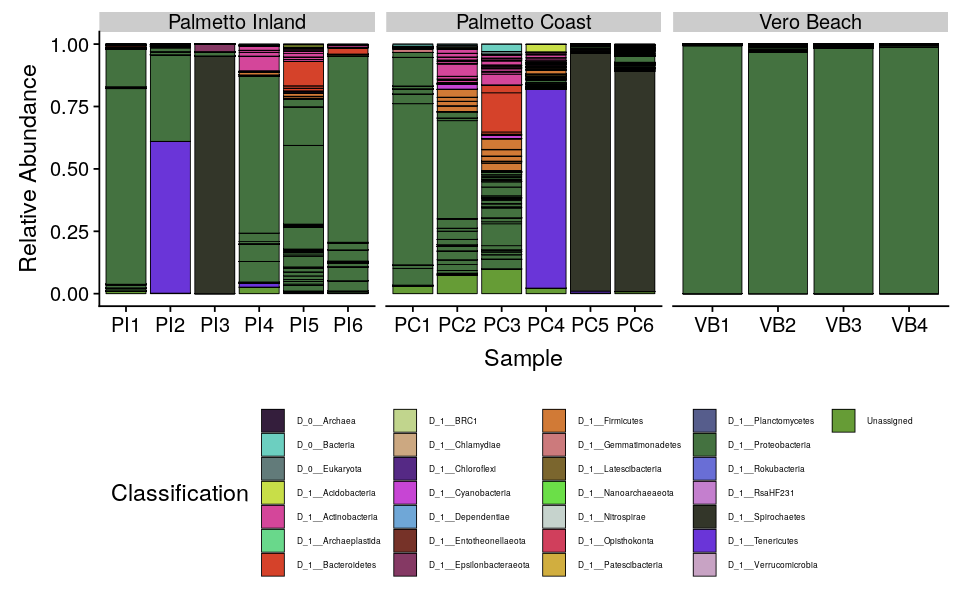

In [10]:
taxonomy_barplot(2)

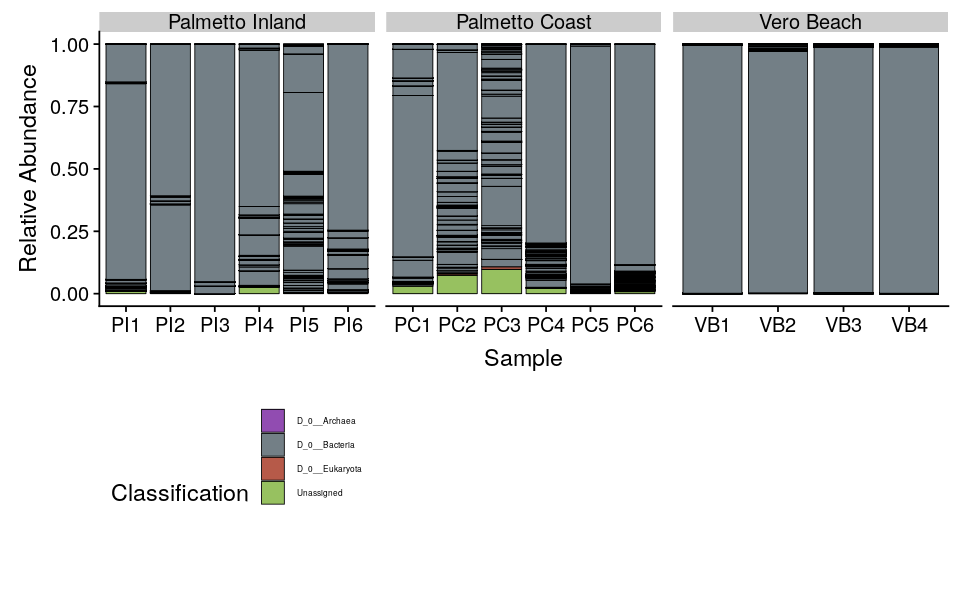

In [11]:
taxonomy_barplot(1)

In [12]:
print_taxon_table <- function(level) {
    taxon_tab <- get_melted_taxon_table(level)
    # Aggregate and normalize by location
    taxon_tab$Location <- md[taxon_tab$SampleID,'location']
    taxon_tab$Location <- as.factor(taxon_tab$Location)
    levels(taxon_tab$Location) <- c("Palmetto Inland", "Palmetto Coast", "Vero Beach")
    taxon_tab <- aggregate(taxon_tab$RelAbund, by=list(taxon_tab$Location, taxon_tab$Classification), FUN=sum)
    colnames(taxon_tab) <- c("Location", "Classification", "RelAbund")
    taxon_tab[taxon_tab$Location == 'Vero Beach','RelAbund'] <- taxon_tab[taxon_tab$Location == 'Vero Beach','RelAbund']/4*100
    taxon_tab[taxon_tab$Location == 'Palmetto Inland','RelAbund'] <- taxon_tab[taxon_tab$Location == 'Palmetto Inland','RelAbund']/6*100
    taxon_tab[taxon_tab$Location == 'Palmetto Coast','RelAbund'] <- taxon_tab[taxon_tab$Location == 'Palmetto Coast','RelAbund']/6*100
    # Round for pretty print
    taxon_tab$RelAbund <- round(taxon_tab$RelAbund, 2)
    # Re-cast as wide for viewing
    taxon_tab <- dcast(data = taxon_tab, formula = Classification~Location,fun.aggregate = sum,value.var = "RelAbund")
    # Order by largest row sums
    taxon_tab <- taxon_tab[order(rowSums(taxon_tab[,2:4]), decreasing=TRUE),]                                    
    taxon_tab
}

In [13]:
print_taxon_table(1)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
2,D_0__Bacteria,99.27,95.73,99.99
4,Unassigned,0.70,3.91,0.01
3,D_0__Eukaryota,0.03,0.37,0.00
1,D_0__Archaea,0.00,0.00,0.00


In [14]:
print_taxon_table(2)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
23,D_1__Proteobacteria,65.32,35.27,99.72
26,D_1__Spirochaetes,15.88,30.60,0.00
27,D_1__Tenericutes,10.39,13.41,0.00
5,D_1__Actinobacteria,2.92,5.66,0.01
7,D_1__Bacteroidetes,2.73,3.55,0.00
15,D_1__Firmicutes,0.66,4.42,0.04
29,Unassigned,0.70,3.91,0.01
11,D_1__Cyanobacteria,0.06,0.67,0.17
2,D_0__Bacteria,0.14,0.75,0.00
4,D_1__Acidobacteria,0.19,0.63,0.00


In [15]:
print_taxon_table(3)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
11,D_2__Alphaproteobacteria,13.45,19.05,98.64
25,D_2__Gammaproteobacteria,51.73,16.18,1.06
43,D_2__Spirochaetia,15.88,30.60,0.00
33,D_2__Mollicutes,10.39,13.41,0.00
10,D_2__Actinobacteria,2.63,4.32,0.01
15,D_2__Bacteroidia,2.73,3.55,0.00
53,Unassigned,0.70,3.91,0.01
14,D_2__Bacilli,0.36,1.70,0.02
20,D_2__Clostridia,0.07,1.85,0.02
37,D_2__Oxyphotobacteria,0.06,0.67,0.17


In [16]:
print_taxon_table(4)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
20,D_3__Acetobacterales,5.77,0.81,98.36
105,D_3__Spirochaetales,15.88,30.60,0.00
98,D_3__Salinisphaerales,28.08,0.01,0.31
54,D_3__Entomoplasmatales,10.39,13.41,0.00
53,D_3__Enterobacteriales,14.33,2.00,0.13
94,D_3__Rickettsiales,0.00,11.14,0.00
80,D_3__Oceanospirillales,0.65,8.77,0.00
88,D_3__Pseudomonadales,6.21,0.97,0.13
104,D_3__Sphingomonadales,3.34,3.13,0.18
92,D_3__Rhizobiales,3.38,2.37,0.09


In [17]:
print_taxon_table(5)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
39,D_3__Acetobacterales D_4__Acetobacteraceae,5.77,0.81,98.35
187,D_3__Spirochaetales D_4__Spirochaetaceae,15.88,30.60,0.00
176,D_3__Salinisphaerales D_4__Salinisphaeraceae,28.07,0.01,0.00
100,D_3__Entomoplasmatales D_4__Spiroplasmataceae,10.39,13.41,0.00
99,D_3__Enterobacteriales D_4__Enterobacteriaceae,14.33,2.00,0.13
173,D_3__Rickettsiales D_4__Rickettsiaceae,0.00,10.77,0.00
147,D_3__Oceanospirillales D_4__Halomonadaceae,0.65,8.77,0.00
186,D_3__Sphingomonadales D_4__Sphingomonadaceae,3.34,3.13,0.18
156,D_3__Pseudomonadales D_4__Pseudomonadaceae,5.85,0.19,0.12
4,Unassigned,0.70,3.91,0.01


In [18]:
print_taxon_table(6)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
87,D_4__Acetobacteraceae D_5__Asaia,5.74,0.07,98.28
311,D_4__Spirochaetaceae D_5__uncultured,15.88,30.60,0.00
293,D_4__Salinisphaeraceae D_5__Salinisphaera,28.07,0.01,0.00
312,D_4__Spiroplasmataceae D_5__Spiroplasma,10.39,13.41,0.00
51,D_3__Enterobacteriales D_4__Enterobacteriaceae,13.51,0.75,0.00
284,D_4__Rickettsiaceae D_5__Candidatus Megaira,0.00,10.77,0.00
202,D_4__Halomonadaceae D_5__Zymobacter,0.03,8.54,0.00
264,D_4__Pseudomonadaceae D_5__Pseudomonas,5.85,0.19,0.12
4,Unassigned,0.70,3.91,0.01
69,D_3__Rhizobiales D_4__Rhizobiaceae,2.31,0.62,0.05


In [19]:
print_taxon_table(7)

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
85,D_4__Acetobacteraceae D_5__Asaia,5.74,0.07,98.28
377,D_5__uncultured D_6__Spironema culicis,15.88,30.60,0.00
351,D_5__Salinisphaera D_6__Salinisphaera hydrothermalis,28.07,0.01,0.00
251,D_4__Spiroplasmataceae D_5__Spiroplasma,10.39,13.41,0.00
51,D_3__Enterobacteriales D_4__Enterobacteriaceae,13.51,0.75,0.00
232,D_4__Rickettsiaceae D_5__Candidatus Megaira,0.00,10.76,0.00
394,D_5__Zymobacter D_6__uncultured gamma proteobacterium,0.03,8.54,0.00
216,D_4__Pseudomonadaceae D_5__Pseudomonas,5.85,0.11,0.12
4,Unassigned,0.70,3.91,0.01
69,D_3__Rhizobiales D_4__Rhizobiaceae,2.31,0.62,0.05


In [20]:
#Peeking at the ASV table to see the dominating taxa
sorted_asvs <- asv_tab_full[order(rowSums(asv_tab_full), decreasing = TRUE),]
sorted_asvs$Taxonomy <- taxonomy[rownames(sorted_asvs),"Taxon"]
asv_tab_melt <- asv_tab_full
asv_tab_melt$id <- rownames(asv_tab_melt)
asv_tab_melt <- melt(asv_tab_melt)
asv_tab_melt$variable <- gsub(pattern="X", replacement = "", x=asv_tab_melt$variable)
asv_tab_melt$location <- md$location[match(asv_tab_melt$variable, rownames(md))]
asv_tab_agg <- aggregate(asv_tab_melt$value, by=list(asv=asv_tab_melt$id, location=asv_tab_melt$location), FUN=sum)

asv_loc_tab <- dcast(asv_tab_agg, asv~location)
asv_loc_tab <- asv_loc_tab[order(rowSums(asv_loc_tab[,2:4]), decreasing=TRUE),]
head(asv_loc_tab,25)
asv_loc_tab$Taxon <- taxonomy[asv_loc_tab$asv,'Taxon']
taxonomy[asv_loc_tab[apply(asv_loc_tab[,2:4],1, min) > 0, "asv"],"Taxon"]
asv_loc_tab[apply(asv_loc_tab[,2:4],1, min) > 0, 2:5]
#Search for specific taxa
#sorted_asvs[grep("Thorsellia", sorted_asvs$Taxonomy),]

Using id as id variables
Using x as value column: use value.var to override.


,asv,B1GF (-82.49683333 27.62796667),"B1P (-82.5526666666666, 27.64048333)",Vero Beach
1183,c8b9b7d30e9c691c55f6aad86fc2eb8d,73935,226794,7
781,8066a946c2bce93a8f4d4dae660448fa,8,38,217551
602,64e629a02a50cf62088c6a47878fadb2,206682,51,0
1476,fef790186b76b2c4a3f6a44d0e19e0d1,33467,276,100675
1016,abee1e9056d2effd74db08e7bd14ec73,1765,54239,0
337,3e5fa90804013842bbc91428155e8224,46286,19,0
728,7749ac7c98a2d244d3c4f774c23f5618,36202,0,0
72,0f1b2ed368ed60dc58ef54f925a9ebbf,35195,19,0
1357,e8797c11ecb2b8f029487937c45b2760,0,33024,0
1456,fb4349ddb6b851c141f902ba3e79c7b2,22140,0,0


[1] D_0__Bacteria;D_1__Spirochaetes;D_2__Spirochaetia;D_3__Spirochaetales;D_4__Spirochaetaceae;D_5__uncultured;D_6__Spironema culicis                    
 [2] D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia                                     
 [3] D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia                                     
 [4] D_0__Bacteria;D_1__Cyanobacteria;D_2__Oxyphotobacteria;D_3__Chloroplast                                                                              
 [5] D_0__Bacteria;D_1__Firmicutes;D_2__Erysipelotrichia;D_3__Erysipelotrichales;D_4__Erysipelotrichaceae;D_5__uncultured;D_6__uncultured bacterium       
 [6] D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Rubritepida;D_6__uncultured bacterium     
 [7] D_0__Bacteria;D_1__Cyanobacteria;D_2__Oxyphotobacteria;D_3__Chloroplast;D_4__Tetradesmus obliquus;D_5__Tetradesmus obliquus;D_6__Tetradesmus obliquus
 [8] D_0__Bacteria;D_1__RsaHF231                                                                                                                          
 [9] D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Enterobacteriales;D_4__Enterobacteriaceae;D_5__Thorsellia;D_6__Thorsellia kenyensis  
[10] D_0__Bacteria;D_1__Epsilonbacteraeota;D_2__Campylobacteria;D_3__Campylobacterales;D_4__Arcobacteraceae;D_5__Arcobacter                               
419 Levels: D_0__Archaea ...

,B1GF (-82.49683333 27.62796667),"B1P (-82.5526666666666, 27.64048333)",Vero Beach,Taxon
1183,73935,226794,7,D_0__Bacteria;D_1__Spirochaetes;D_2__Spirochaetia;D_3__Spirochaetales;D_4__Spirochaetaceae;D_5__uncultured;D_6__Spironema culicis
781,8,38,217551,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia
1476,33467,276,100675,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Asaia
213,46,13,465,D_0__Bacteria;D_1__Cyanobacteria;D_2__Oxyphotobacteria;D_3__Chloroplast
215,168,176,17,D_0__Bacteria;D_1__Firmicutes;D_2__Erysipelotrichia;D_3__Erysipelotrichales;D_4__Erysipelotrichaceae;D_5__uncultured;D_6__uncultured bacterium
703,36,156,149,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria;D_3__Acetobacterales;D_4__Acetobacteraceae;D_5__Rubritepida;D_6__uncultured bacterium
474,32,172,73,D_0__Bacteria;D_1__Cyanobacteria;D_2__Oxyphotobacteria;D_3__Chloroplast;D_4__Tetradesmus obliquus;D_5__Tetradesmus obliquus;D_6__Tetradesmus obliquus
214,150,101,23,D_0__Bacteria;D_1__RsaHF231
230,67,94,13,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Enterobacteriales;D_4__Enterobacteriaceae;D_5__Thorsellia;D_6__Thorsellia kenyensis
800,18,63,65,D_0__Bacteria;D_1__Epsilonbacteraeota;D_2__Campylobacteria;D_3__Campylobacterales;D_4__Arcobacteraceae;D_5__Arcobacter


In [22]:
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 17.04

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.7.0
LAPACK: /usr/lib/lapack/liblapack.so.3.7.0

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] hues_0.1       reshape2_1.4.3 cowplot_0.9.3  ggplot2_3.0.0 

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.18         compiler_3.4.3       pillar_1.3.0        
 [4] plyr_1.8.4           bindr_0.1.1          base64enc_0.1-3     
 [7] tools_3.4.3          digest_0.6.15        uuid_0.1-2      